# Import Library & Setup Environment

In [13]:
# ==========================
# General Utilities
# ==========================
import os
import joblib
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Image Processing
# ==========================
import cv2
from PIL import Image
import mahotas
from mahotas.features import zernike_moments
from skimage.feature import hog, local_binary_pattern
from scipy.fft import fft2
import pywt
from scipy.stats import skew, kurtosis

# ==========================
# Machine Learning (Classical)
# ==========================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# ==========================
# Deep Learning
# ==========================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==========================
# Gradient Boosting Models
# ==========================
from xgboost import XGBClassifier


# Tahap 1: Exploratory Data Analysis (EDA)

In [2]:
data_dir = "dataset"

classes = os.listdir(data_dir)
data_count = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

for k, v in data_count.items():
    print(f"{k}: {v} gambar ({v/sum(data_count.values())*100:.2f}%)")

Mild Impairment: 2264 gambar (23.18%)
Moderate Impairment: 2217 gambar (22.70%)
No Impairment: 2767 gambar (28.33%)
Very Mild Impairment: 2518 gambar (25.78%)


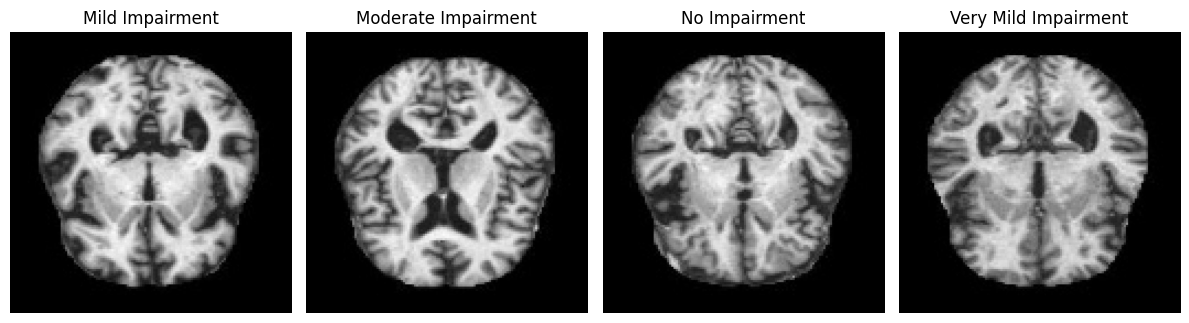

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax, cls in zip(axes, classes):
    sample_img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = Image.open(sample_img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [4]:
sizes = []
modes = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(cls_path)[:30]:
        img = Image.open(os.path.join(cls_path, img_name))
        sizes.append(img.size)
        modes.append(img.mode)

sizes = np.array(sizes)

print(f"Rata-rata ukuran gambar: {sizes[:,0].mean():.0f} x {sizes[:,1].mean():.0f}")
print(f"Mode warna yang umum: {pd.Series(modes).mode()[0]}")

Rata-rata ukuran gambar: 640 x 640
Mode warna yang umum: RGB


# Tahap 2: Preprocessing Data

In [ ]:
data_dir = "dataset"
IMG_SIZE = (224, 224)  # ukuran target gambar

class_names = sorted(os.listdir(data_dir))
print("Kelas yang terdeteksi:", class_names)


Kelas yang terdeteksi: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [6]:
image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_folder, filename))
            labels.append(class_name)

df = pd.DataFrame({
    'filename': image_paths,
    'label': labels
})

In [7]:
# Label encoding numerik
label_to_index = {name: idx for idx, name in enumerate(class_names)}
df['label_idx'] = df['label'].map(label_to_index)

# Split utama: 80% train+val, 20% test
trainval_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label_idx'], random_state=42
)

# Dari 80% train+val, ambil 25% untuk validation → hasil akhirnya 60:20:20
train_df, val_df = train_test_split(
    trainval_df, test_size=0.25, stratify=trainval_df['label_idx'], random_state=42
)

print(f"Train: {len(train_df)} ({len(train_df)/len(df):.2%})")
print(f"Validation: {len(val_df)} ({len(val_df)/len(df):.2%})")
print(f"Test: {len(test_df)} ({len(test_df)/len(df):.2%})")


Train: 5859 (59.99%)
Validation: 1953 (20.00%)
Test: 1954 (20.01%)


In [ ]:
def preprocess_image(path):
    # Baca gambar
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # CLAHE untuk meningkatkan kontras (pada channel L di LAB)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    # Normalisasi ke rentang [0, 1]
    img = img / 255.0
    return img


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 5859 validated image filenames belonging to 4 classes.
Found 1953 validated image filenames belonging to 4 classes.
Found 1954 validated image filenames belonging to 4 classes.


In [11]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx']
)
class_weights = dict(enumerate(class_weights_array))

print("Class Weights:")
for k, v in class_weights.items():
    print(f"  {class_names[k]}: {v:.3f}")


Class Weights:
  Mild Impairment: 1.079
  Moderate Impairment: 1.101
  No Impairment: 0.882
  Very Mild Impairment: 0.969


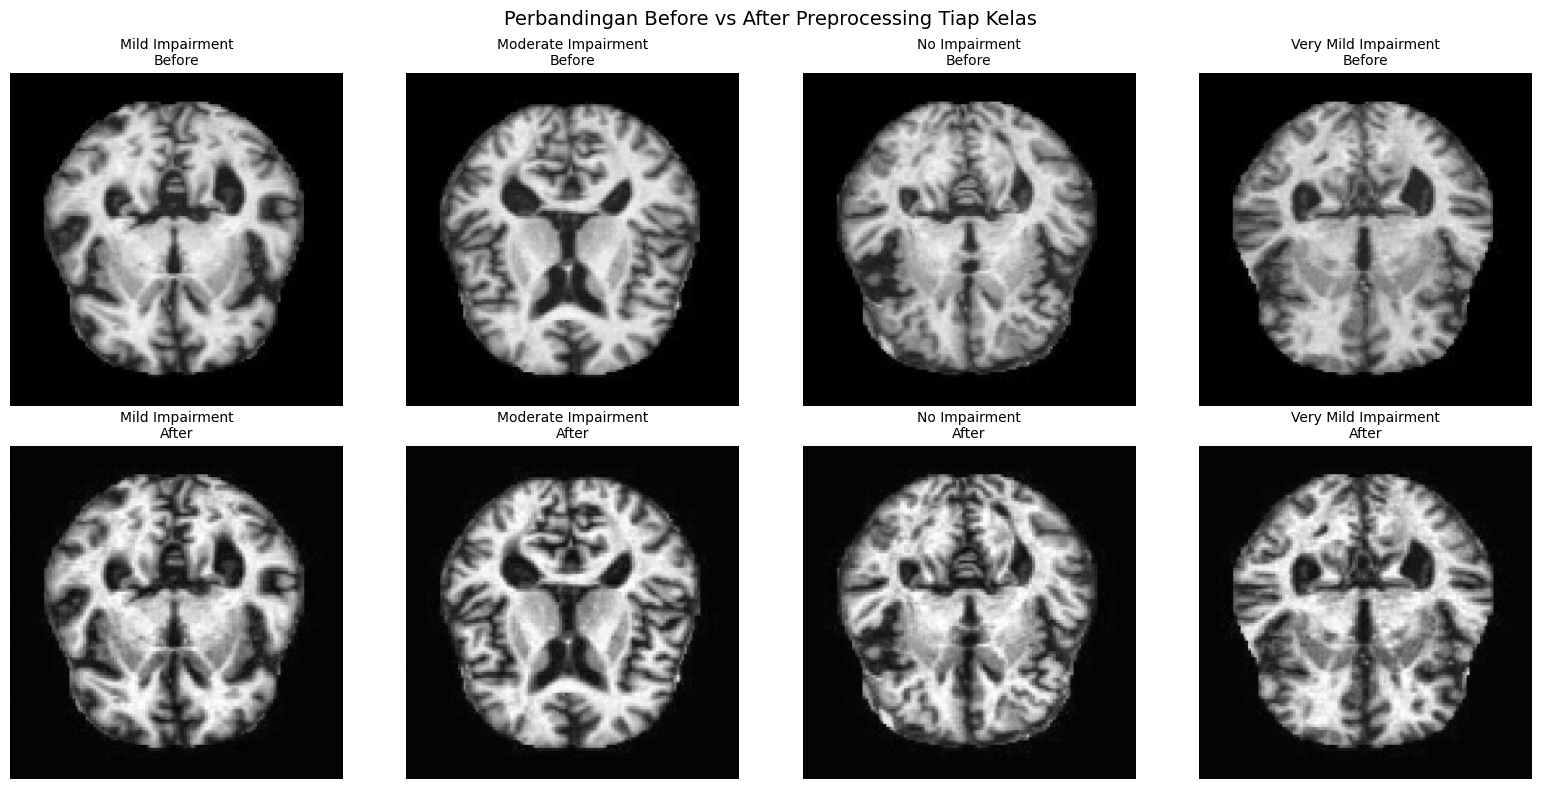

In [12]:
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, cls in enumerate(classes):
    sample_img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    
    img_before = Image.open(sample_img_path)
    axes[0, i].imshow(img_before)
    axes[0, i].set_title(f"{cls}\nBefore", fontsize=10)
    axes[0, i].axis("off")

    img_after = preprocess_image(sample_img_path)
    axes[1, i].imshow(img_after)
    axes[1, i].set_title(f"{cls}\nAfter", fontsize=10)
    axes[1, i].axis("off")

plt.suptitle("Perbandingan Before vs After Preprocessing Tiap Kelas", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
output_base = "processed_dataset"
splits = ["train", "val", "test"]

for split in splits:
    for cls in class_names:
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)


def save_preprocessed_image(input_path, output_path):
    # Menyimpan gambar hasil preprocessing ke output_path
    try:
        img = preprocess_image(input_path)
        img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, img_bgr)
    except Exception as e:
        print(f"Gagal memproses {input_path}: {e}")


def process_subset(subset_df, subset_name):
    # Proses subset (train/val/test) dan simpan hasil preprocessing
    print(f"\nMemproses subset: {subset_name} ({len(subset_df)} gambar)")
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
        input_path = row['filename']
        label = row['label']
        fname = os.path.basename(input_path)
        output_path = os.path.join(output_base, subset_name, label, fname)

        if not os.path.exists(output_path):
            save_preprocessed_image(input_path, output_path)

    print(f"Selesai: {subset_name} ({len(subset_df)} gambar)")

process_subset(train_df, "train")
process_subset(val_df, "val")
process_subset(test_df, "test")

print("\nSemua gambar berhasil diproses dan dibagi ke folder train, val, dan test.")


Memproses subset: train (5859 gambar)


100%|██████████| 5859/5859 [00:00<00:00, 19633.53it/s]


Selesai: train (5859 gambar)

Memproses subset: val (1953 gambar)


100%|██████████| 1953/1953 [00:00<00:00, 14046.70it/s]


Selesai: val (1953 gambar)

Memproses subset: test (1954 gambar)


100%|██████████| 1954/1954 [00:00<00:00, 22133.47it/s]

Selesai: test (1954 gambar)

Semua gambar berhasil diproses dan dibagi ke folder train, val, dan test.


In [14]:
def check_corrupted_images(base_dir):
    corrupted_files = []
    total_files = 0
    ok_files = 0

    for root, _, files in os.walk(base_dir):
        for fname in files:
            if fname.lower().endswith(('.jpg')):
                total_files += 1
                fpath = os.path.join(root, fname)
                try:
                    with Image.open(fpath) as img:
                        img.verify()
                    ok_files += 1
                except Exception as e:
                    corrupted_files.append((fpath, str(e)))

    print(f"Total file diperiksa: {total_files}")
    print(f"File valid: {ok_files}")
    print(f"File korup: {len(corrupted_files)}")

    if corrupted_files:
        print("\nDaftar file korup:")
        for f, err in corrupted_files[:10]:
            print(f"  {f} → {err}")

    return corrupted_files

corrupted = check_corrupted_images("processed_dataset")

Total file diperiksa: 9766
File valid: 9766
File korup: 0


# Tahap 3: Ekstraksi Fitur Klasik

## Jenis-jenis Ekstraksi Fitur

0. Konfigurasi Data

In [ ]:
base_dir = "processed_dataset"
output_dir = "features_extracted"
splits = ["train", "val", "test"]
classes = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]
RESIZE_SHAPE = (128, 128)

# Pastikan folder output ada
os.makedirs(output_dir, exist_ok=True)

1. Ekstraksi Fitur LBP (Local Binary Patterns)

In [ ]:
# Parameter LBP
LBP_RADIUS = 2
LBP_POINTS = 8 * LBP_RADIUS
RESIZE_SHAPE = (128, 128)  # Samakan ukuran gambar

# Fungsi Ekstraksi LBP
def extract_lbp_features(image_gray):
    """Ekstraksi fitur tekstur menggunakan Local Binary Pattern (LBP)."""
    lbp = local_binary_pattern(image_gray, LBP_POINTS, LBP_RADIUS, method='uniform')
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2)
    )
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalisasi histogram
    return hist

# Proses Ekstraksi dari Folder Dataset
def extract_features_from_dataset():
    data = []
    print(f"\n[INFO] Memulai ekstraksi LBP untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    img = cv2.resize(img, RESIZE_SHAPE)
                    lbp_feat = extract_lbp_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(lbp_feat)})
                    data.append(feature_row)
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    return pd.DataFrame(data)

# Jalankan Proses Ekstraksi
df_all = extract_features_from_dataset()

# Simpan ke file CSV
os.makedirs("features_extracted", exist_ok=True)
output_path = os.path.join("features_extracted", "features_lbp_full.csv")
df_all.to_csv(output_path, index=False)

# Ringkasan
num_features = len([c for c in df_all.columns if c.startswith('f')])
print("\nEkstraksi LBP selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi LBP untuk seluruh dataset di 'processed_dataset' ...



Ekstraksi LBP selesai.
   Total data    : 9766
   Jumlah fitur  : 19
   File disimpan : features_extracted\features_lbp_full.csv


2. Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

In [ ]:
# Parameter HOG
HOG_PARAMS = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys",
    "transform_sqrt": True
}

RESIZE_SHAPE = (128, 128)

def extract_hog_features(image_gray):
    # Ekstraksi fitur bentuk/tepi menggunakan Histogram of Oriented Gradients (HOG).
    image_gray = cv2.resize(image_gray, RESIZE_SHAPE)
    features = hog(image_gray, **HOG_PARAMS)
    return features

# Ekstraksi fitur dari seluruh dataset
def extract_hog_from_dataset():
    data = []
    total = 0

    print(f"\n[INFO] Memulai ekstraksi HOG untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    feat = extract_hog_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(feat)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    return pd.DataFrame(data)

# Jalankan Ekstraksi
df_all = extract_hog_from_dataset()

# Simpan hasil
output_path = os.path.join(output_dir, "features_hog_full.csv")
df_all.to_csv(output_path, index=False)

# Ringkasan
num_features = len([c for c in df_all.columns if c.startswith('f')])
print("\nEkstraksi HOG selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi HOG untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi HOG selesai.
   Total data    : 9766
   Jumlah fitur  : 8101
   File disimpan : features_extracted\features_hog_full.csv


3. Ekstraksi Fitur Zernike Moments

In [ ]:
# Parameter Zernike
ZERN_RADIUS = 64
ZERN_DEGREE = 8
RESIZE_SHAPE = (ZERN_RADIUS * 2, ZERN_RADIUS * 2)

def extract_zernike_features(image_gray, radius=ZERN_RADIUS, degree=ZERN_DEGREE):
    # Resize gambar agar simetris dan sesuai radius
    image_gray = cv2.resize(image_gray, RESIZE_SHAPE)
    # Normalisasi dan konversi ke biner (threshold adaptif agar tidak salah segmentasi)
    _, binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = binary.astype(np.uint8)
    # Hitung Zernike Moments
    return zernike_moments(binary, radius, degree=degree)

# Proses Ekstraksi dari Folder Dataset
def extract_zernike_from_dataset():
    data = []
    total = 0

    print(f"\n[INFO] Memulai ekstraksi Zernike Moments untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    feat = extract_zernike_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(feat)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    return pd.DataFrame(data)

# Jalankan Ekstraksi
df_all = extract_zernike_from_dataset()

# Simpan hasil
output_path = os.path.join(output_dir, "features_zernike_full.csv")
df_all.to_csv(output_path, index=False)

# Ringkasan
num_features = len([c for c in df_all.columns if c.startswith('f')])
print("\nEkstraksi Zernike Moments selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Zernike Moments untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi Zernike Moments selesai.
   Total data    : 9766
   Jumlah fitur  : 26
   File disimpan : features_extracted\features_zernike_full.csv


4. Ekstraksi Fitur Wavelet Features

In [ ]:
# Parameter Wavelet
WAVELET_FAMILIES = ('haar', 'db4', 'sym5', 'coif1')
WAVELET_LEVEL = 3
RESIZE_SHAPE = (128, 128)

def extract_wavelet_features(image_gray, families=WAVELET_FAMILIES, level=WAVELET_LEVEL):
    # Ekstraksi fitur Wavelet multi-level & multi-family dengan statistik dasar (mean, std, skewness, kurtosis)
    features = []
    for wavelet in families:
        coeffs = pywt.wavedec2(image_gray, wavelet=wavelet, level=level)
        for i, coeff in enumerate(coeffs):
            if i == 0:
                cA = coeff
                stats = [np.mean(cA), np.std(cA), skew(cA.flatten()), kurtosis(cA.flatten())]
                features.extend(stats)
            else:
                cH, cV, cD = coeff
                for c in [cH, cV, cD]:
                    stats = [np.mean(c), np.std(c), skew(c.flatten()), kurtosis(c.flatten())]
                    features.extend(stats)
    return np.array(features, dtype=float)

# Ekstraksi Fitur Wavelet dari Seluruh Dataset
def extract_wavelet_from_dataset():
    data = []
    total = 0

    print(f"\n[INFO] Memulai ekstraksi Wavelet untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                try:
                    img = cv2.resize(img, RESIZE_SHAPE)
                    img = cv2.equalizeHist(img)

                    feat = extract_wavelet_features(img)
                    feature_row = {
                        'file_path': fpath,
                        'label': label,
                        'split': split
                    }
                    feature_row.update({f'f{i}': v for i, v in enumerate(feat)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    return pd.DataFrame(data)

# Jalankan Ekstraksi
df_all = extract_wavelet_from_dataset()

# Bersihkan NaN (jika ada)
feature_cols = [c for c in df_all.columns if c.startswith('f')]
df_all[feature_cols] = df_all[feature_cols].apply(pd.to_numeric, errors='coerce')
nan_count = df_all[feature_cols].isna().sum().sum()
if nan_count > 0:
    print(f"[WARN] Ditemukan {nan_count} nilai NaN, akan diganti dengan 0.")
    df_all[feature_cols] = df_all[feature_cols].fillna(0)

# Simpan ke File CSV
output_path = os.path.join(output_dir, "features_wavelet_full.csv")
df_all.to_csv(output_path, index=False)

# Ringkasan
num_features = len(feature_cols)
print("\nEkstraksi Wavelet selesai.")
print(f"   Total data    : {len(df_all)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Wavelet untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766
[WARN] Ditemukan 9766 nilai NaN, akan diganti dengan 0.

Ekstraksi Wavelet selesai.
   Total data    : 9766
   Jumlah fitur  : 161
   File disimpan : features_extracted\features_wavelet_full.csv


5. Ekstraksi Fitur GLCM (Gray Level Co-occurrence Matrix)

In [ ]:
# Fungsi Ekstraksi Haralick multi-block
NUM_BLOCKS = 4
def extract_haralick_multiblock(img_gray, num_blocks=NUM_BLOCKS):
    img_resized = cv2.resize(img_gray, RESIZE_SHAPE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_resized)

    block_size = RESIZE_SHAPE[0] // num_blocks
    features = []

    for i in range(num_blocks):
        for j in range(num_blocks):
            patch = img_eq[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            haralick = mahotas.features.haralick(patch).mean(axis=0)
            features.extend(haralick)

    return np.array(features, dtype=float)

# Ekstraksi dataset
def extract_haralick_dataset():
    data = []
    total = 0
    print(f"\n[INFO] Memulai ekstraksi Haralick multi-block untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                try:
                    features = extract_haralick_multiblock(img)
                    feature_row = {'file_path': fpath, 'label': label, 'split': split}
                    feature_row.update({f'f{i}': v for i, v in enumerate(features)})
                    data.append(feature_row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# Jalankan ekstraksi
df_haralick = extract_haralick_dataset()
output_path = os.path.join(output_dir, "features_glcm_multiblock.csv")
df_haralick.to_csv(output_path, index=False)

# Ringkasan
num_features = len([c for c in df_haralick.columns if c.startswith('f')])
print("\nEkstraksi Haralick multi-block selesai.")
print(f"   Total data    : {len(df_haralick)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Haralick multi-block untuk seluruh dataset di 'processed_dataset' ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi Haralick multi-block selesai.
   Total data    : 9766
   Jumlah fitur  : 209
   File disimpan : features_extracted\features_glcm_multiblock.csv


6. Ekstraksi Fitur FFT (Fast Fourier Transform)

In [ ]:
TOP_N = 256  # jumlah fitur FFT yang disimpan

def extract_fft_features(img_gray):
    fft_img = fft2(img_gray)
    fft_mag = np.abs(fft_img).flatten()  # type: ignore
    if len(fft_mag) > TOP_N:
        fft_mag = fft_mag[:TOP_N]
    else:
        fft_mag = np.pad(fft_mag, (0, TOP_N - len(fft_mag)))
    return fft_mag

def extract_fft_dataset():
    data = []
    total = 0

    print(f"[INFO] Memulai ekstraksi FFT untuk seluruh dataset di '{base_dir}' ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                print(f"[SKIP] Folder tidak ditemukan: {folder_path}")
                continue

            image_files = [f for f in os.listdir(folder_path)
                           if f.lower().endswith(('.jpg','.png','.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, RESIZE_SHAPE)
                img = cv2.equalizeHist(img)

                feats = extract_fft_features(img)
                row = {'file_path': fpath, 'label': label, 'split': split}
                row.update({f'f{i}': v for i,v in enumerate(feats)})
                data.append(row)
                total += 1

    print(f"[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# Ekstraksi FFT seluruh dataset
df_fft = extract_fft_dataset()

# Simpan ke CSV
output_path = os.path.join(output_dir,"features_fft_full.csv")
df_fft.to_csv(output_path, index=False)
print(f"[INFO] FFT extraction done. File saved to: {output_path}")


[INFO] Memulai ekstraksi FFT untuk seluruh dataset di 'processed_dataset' ...


[INFO] Total gambar berhasil diproses: 9766
[INFO] FFT extraction done. File saved to: features_extracted\features_fft_full.csv


7. Ekstraksi Fitur GIST Descriptors

In [ ]:
# Gabor parameters
GABOR_THETAS = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6]
GABOR_SCALES = [4, 8, 16]  # ukuran kernel
GABOR_LAMBDA = 10.0
GABOR_GAMMA = 0.5
GABOR_PSI = 0

os.makedirs(output_dir, exist_ok=True)

# Fungsi ekstraksi GIST-like multi-block
def extract_gist_like_multiblock(img_gray, num_blocks=NUM_BLOCKS):
    img_resized = cv2.resize(img_gray, RESIZE_SHAPE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_resized)

    block_size = RESIZE_SHAPE[0] // num_blocks
    features = []

    for i in range(num_blocks):
        for j in range(num_blocks):
            patch = img_eq[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            for theta in GABOR_THETAS:
                for ksize in GABOR_SCALES:
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma=4.0, theta=theta,
                                                lambd=GABOR_LAMBDA, gamma=GABOR_GAMMA, psi=GABOR_PSI)
                    filtered = cv2.filter2D(patch, cv2.CV_32F, kernel)
                    features.extend([filtered.mean(), filtered.std()])

    return np.array(features, dtype=float)

# Ekstraksi dataset
def extract_gist_like_dataset():
    data = []
    total = 0
    print(f"\n[INFO] Memulai ekstraksi GIST-like multi-block untuk seluruh dataset ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                continue
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                try:
                    feats = extract_gist_like_multiblock(img)
                    row = {'file_path': fpath, 'label': label, 'split': split}
                    row.update({f'f{i}': v for i, v in enumerate(feats)})
                    data.append(row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# Jalankan ekstraksi
df_gist_like = extract_gist_like_dataset()
output_path = os.path.join(output_dir, "features_gist_like_multiblock.csv")
df_gist_like.to_csv(output_path, index=False)

# Ringkasan
num_features = len([c for c in df_gist_like.columns if c.startswith('f')])
print("\nEkstraksi GIST-like multi-block selesai.")
print(f"   Total data    : {len(df_gist_like)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi GIST-like multi-block untuk seluruh dataset ...


train/Mild Impairment:   0%|          | 0/1358 [00:00<?, ?it/s]


[INFO] Total gambar berhasil diproses: 9766

Ekstraksi GIST-like multi-block selesai.
   Total data    : 9766
   Jumlah fitur  : 769
   File disimpan : features_extracted\features_gist_like_multiblock.csv


8. Ekstraksi Fitur Hu moment

In [ ]:
# Fungsi ekstraksi Hu Moments multi-patch
NUM_PATCHES = 4
def extract_hu_moments_multiscale(img_gray, num_patches=NUM_PATCHES):
    """
    Ekstraksi Hu Moments untuk setiap patch citra.
    img_gray : citra grayscale
    num_patches : jumlah patch per sisi (num_patches x num_patches)
    """
    # Resize dan CLAHE
    img_resized = cv2.resize(img_gray, RESIZE_SHAPE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_eq = clahe.apply(img_resized)

    patch_size = RESIZE_SHAPE[0] // num_patches
    features = []

    for i in range(num_patches):
        for j in range(num_patches):
            patch = img_eq[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            moments = cv2.moments(patch)
            hu = cv2.HuMoments(moments).flatten()
            # Log transform untuk stabilitas skala
            hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
            features.extend(hu_log)

    return np.array(features, dtype=float)

# Ekstraksi dataset
def extract_hu_moments_dataset():
    data = []
    total = 0
    print(f"\n[INFO] Memulai ekstraksi Hu Moments multi-patch untuk seluruh dataset ...")

    for split in splits:
        for label in classes:
            folder_path = os.path.join(base_dir, split, label)
            if not os.path.exists(folder_path):
                continue
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]

            for fname in tqdm(image_files, desc=f"{split}/{label}", leave=False):
                fpath = os.path.join(folder_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                try:
                    feats = extract_hu_moments_multiscale(img)
                    row = {'file_path': fpath, 'label': label, 'split': split}
                    row.update({f'f{i}': v for i, v in enumerate(feats)})
                    data.append(row)
                    total += 1
                except Exception as e:
                    print(f"[SKIP] {fpath}: {e}")

    print(f"\n[INFO] Total gambar berhasil diproses: {total}")
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    return df

# Jalankan ekstraksi
df_hu = extract_hu_moments_dataset()
output_path = os.path.join(output_dir, "features_hu_moments_multi_patch.csv")
df_hu.to_csv(output_path, index=False)

# Ringkasan
num_features = len([c for c in df_hu.columns if c.startswith('f')])
print("\nEkstraksi Hu Moments multi-patch selesai.")
print(f"   Total data    : {len(df_hu)}")
print(f"   Jumlah fitur  : {num_features}")
print(f"   File disimpan : {output_path}")



[INFO] Memulai ekstraksi Hu Moments multi-patch untuk seluruh dataset ...



[INFO] Total gambar berhasil diproses: 9766

Ekstraksi Hu Moments multi-patch selesai.
   Total data    : 9766
   Jumlah fitur  : 113
   File disimpan : features_extracted\features_hu_moments_multi_patch.csv


## Training Model (XGBoost)

In [ ]:
# Folder fitur
features_dir = "features_extracted"
output_dir = "trained_models"
os.makedirs(output_dir, exist_ok=True)

# File CSV fitur
files = {
    "hog": "features_hog.csv",
    "zernike": "features_zernike.csv",
    "wavelet": "features_wavelet.csv",
    "glcm": "features_glcm_multiblock.csv",
    "lbp": "features_lbp.csv",
    "fft": "features_fft.csv",
    "gist": "features_gist_like_multiblock.csv",
    "hu": "features_hu_moments_multi_patch.csv"
}

for name, fname in files.items():
    fpath = os.path.join(features_dir, fname)
    if not os.path.exists(fpath):
        print(f"[WARN] File tidak ditemukan: {fpath}")
        continue

    df = pd.read_csv(fpath)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        print(f"[SKIP] File {fname} tidak memiliki kolom numerik")
        continue

    X = df[numeric_cols].fillna(0)
    y = df['label']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split train / val / test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
    )
    # 60% train, 20% val, 20% test

    # XGBoost dengan eval_set untuk loss & akurasi
    xgb_model = XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    # Ambil evals_result untuk plot loss & aprox accuracy
    evals_result = xgb_model.evals_result()
    xgb_train_loss = evals_result['validation_0']['mlogloss']
    xgb_val_loss = evals_result['validation_1']['mlogloss']
    # Aproksimasi akurasi dari logloss
    xgb_train_acc = [1 - l/max(xgb_train_loss) for l in xgb_train_loss]
    xgb_val_acc = [1 - l/max(xgb_val_loss) for l in xgb_val_loss]

    # Simpan model, scaler, label encoder, dan data siap plot
    save_path = os.path.join(output_dir, f"{name}_xgb_model.pkl")
    joblib.dump({
        "xgb": xgb_model,
        "label_encoder": le,
        "scaler": scaler,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
        "xgb_train_loss": xgb_train_loss,
        "xgb_val_loss": xgb_val_loss,
        "xgb_train_acc": xgb_train_acc,
        "xgb_val_acc": xgb_val_acc
    }, save_path)

    print(f"[INFO] XGBoost Model {name} berhasil disimpan -> {save_path}")


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:28:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model hog berhasil disimpan -> trained_models\hog_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:39:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model zernike berhasil disimpan -> trained_models\zernike_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:39:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model wavelet berhasil disimpan -> trained_models\wavelet_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:39:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model glcm berhasil disimpan -> trained_models\glcm_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:40:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model lbp berhasil disimpan -> trained_models\lbp_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:40:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model fft berhasil disimpan -> trained_models\fft_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model gist berhasil disimpan -> trained_models\gist_xgb_model.pkl


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:42:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] XGBoost Model hu berhasil disimpan -> trained_models\hu_xgb_model.pkl


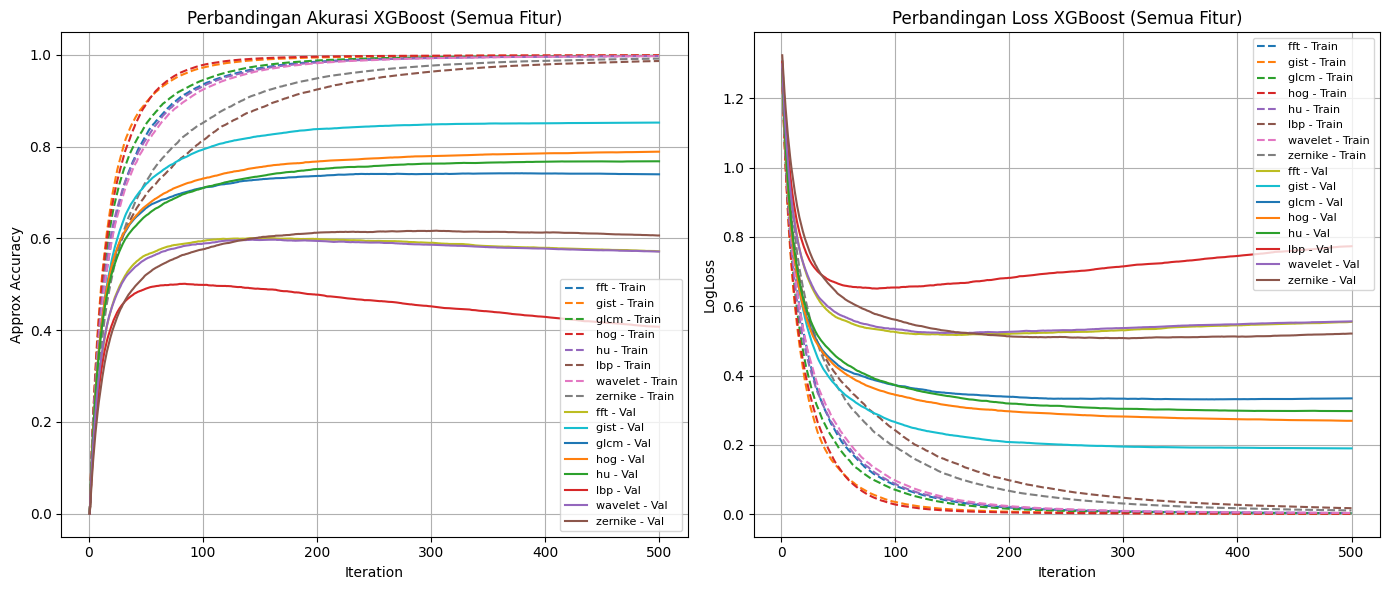

[INFO] Plot gabungan Accuracy & Loss XGBoost disimpan -> visualisasi\xgb_combined_accuracy_loss.png


In [ ]:
# visualisasi accuracy loss

# Direktori input-output
model_dir = "trained_models"
plot_dir = "visualisasi"
os.makedirs(plot_dir, exist_ok=True)

# Simpan semua hasil untuk digabungkan
train_acc_dict = {}
val_acc_dict = {}
train_loss_dict = {}
val_loss_dict = {}

for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    xgb_train_acc = data.get("xgb_train_acc", None)
    xgb_val_acc = data.get("xgb_val_acc", None)
    xgb_train_loss = data.get("xgb_train_loss", None)
    xgb_val_loss = data.get("xgb_val_loss", None)

    if xgb_train_acc and xgb_val_acc:
        train_acc_dict[feature_name] = xgb_train_acc
        val_acc_dict[feature_name] = xgb_val_acc
    if xgb_train_loss and xgb_val_loss:
        train_loss_dict[feature_name] = xgb_train_loss
        val_loss_dict[feature_name] = xgb_val_loss

# Plot gabungan semua feature (Accuracy & Loss)
plt.figure(figsize=(14,6))

# Subplot kiri: Akurasi
plt.subplot(1,2,1)
for feature_name, acc in train_acc_dict.items():
    plt.plot(range(1, len(acc)+1), acc, linestyle='--', label=f"{feature_name} - Train")
for feature_name, acc in val_acc_dict.items():
    plt.plot(range(1, len(acc)+1), acc, label=f"{feature_name} - Val")
plt.title("Perbandingan Akurasi XGBoost (Semua Fitur)")
plt.xlabel("Iteration")
plt.ylabel("Approx Accuracy")
plt.legend(fontsize=8)
plt.grid(True)

# Subplot kanan: Loss
plt.subplot(1,2,2)
for feature_name, loss in train_loss_dict.items():
    plt.plot(range(1, len(loss)+1), loss, linestyle='--', label=f"{feature_name} - Train")
for feature_name, loss in val_loss_dict.items():
    plt.plot(range(1, len(loss)+1), loss, label=f"{feature_name} - Val")
plt.title("Perbandingan Loss XGBoost (Semua Fitur)")
plt.xlabel("Iteration")
plt.ylabel("LogLoss")
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
save_path = os.path.join(plot_dir, "xgb_combined_accuracy_loss.png")
plt.savefig(save_path)
plt.show()

print(f"[INFO] Plot gabungan Accuracy & Loss XGBoost disimpan -> {save_path}")


[INFO] Total prediksi gabungan: 15624 sampel dari 8 model.


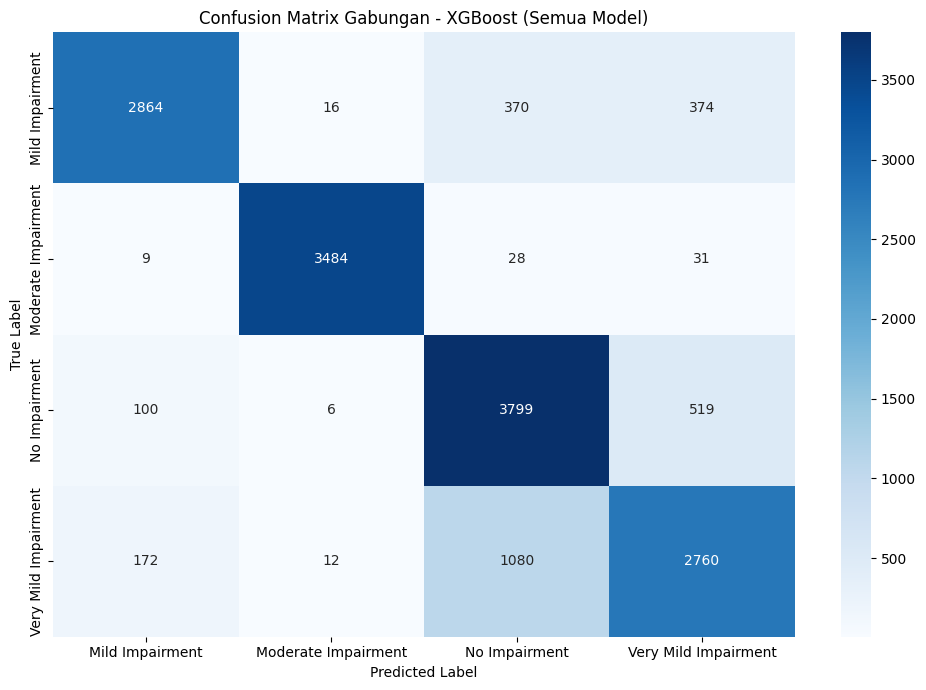

[INFO] Confusion matrix gabungan disimpan -> visualisasi\confusion_matrix_gabungan_xgb.png


In [ ]:
# error analysis



# Direktori input-output

model_dir = "trained_models"
output_dir = os.path.join("visualisasi")  # Folder untuk hasil visualisasi
os.makedirs(output_dir, exist_ok=True)


# Variabel penampung gabungan

all_y_true = []
all_y_pred = []
all_labels = None


# Loop semua model XGB

for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    xgb = data["xgb"]
    le = data["label_encoder"]

    X_val = data.get("X_val", data["X_test"])
    y_val = data.get("y_val", data["y_test"])
    y_pred = xgb.predict(X_val)

    # Simpan semua prediksi dan label
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    # Simpan label encoder untuk referensi kelas
    if all_labels is None:
        all_labels = le.classes_

print(f"[INFO] Total prediksi gabungan: {len(all_y_true)} sampel dari {len(os.listdir(model_dir))} model.")

# Buat 1 confusion matrix gabungan
cm = confusion_matrix(all_y_true, all_y_pred)
cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Gabungan - XGBoost (Semua Model)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

cm_path = os.path.join(output_dir, "confusion_matrix_gabungan_xgb.png")
plt.savefig(cm_path)
plt.show()
print(f"[INFO] Confusion matrix gabungan disimpan -> {cm_path}")


## Evaluasi

In [ ]:
# evaluasi validation models

model_dir = "trained_models"
output_dir = "summary"  # folder output
os.makedirs(output_dir, exist_ok=True)

txt_path = os.path.join(output_dir, "all_models_evaluation_summary.txt")
lines_to_write = []
lines_to_write.append("=== ALL MODELS EVALUATION SUMMARY ===\n")

for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    le = data["label_encoder"]

    # Pastikan ada X_val & y_val, jika tidak fallback ke X_test & y_test
    X_val = data.get("X_val", data["X_test"])
    y_val = data.get("y_val", data["y_test"])

    # Evaluasi XGBoost pada Validation Set
    y_pred_xgb = data["xgb"].predict(X_val)
    acc_xgb = accuracy_score(y_val, y_pred_xgb)
    class_report = classification_report(y_val, y_pred_xgb, target_names=le.classes_)

    # Tulis ke list dan print ke layar (tanpa confusion matrix)
    output_lines = [
        f"\n=== Evaluasi Fitur: {feature_name} | Model: XGBoost (Validation) ===",
        f"Akurasi: {acc_xgb*100:.2f}%",
        "Classification Report:",
        class_report,
        "-"*80
    ]
    
    # Tambahkan ke lines_to_write
    lines_to_write.extend(output_lines)
    
    # Print ke layar
    print("\n".join(output_lines))

# Simpan ke file tunggal
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines_to_write))

print(f"\n[INFO] Semua hasil evaluasi disimpan -> {txt_path}")



=== Evaluasi Fitur: fft | Model: XGBoost (Validation) ===
Akurasi: 78.19%
Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.89      0.75      0.81       453
 Moderate Impairment       1.00      0.99      0.99       444
       No Impairment       0.65      0.83      0.73       553
Very Mild Impairment       0.68      0.58      0.63       503

            accuracy                           0.78      1953
           macro avg       0.81      0.79      0.79      1953
        weighted avg       0.79      0.78      0.78      1953

--------------------------------------------------------------------------------

=== Evaluasi Fitur: gist | Model: XGBoost (Validation) ===
Akurasi: 92.93%
Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.91      0.94       453
 Moderate Impairment       1.00      1.00      1.00       444
       No Impairment       0.87     

In [ ]:
# error analysis summary

model_dir = "trained_models"
output_dir = "summary"
os.makedirs(output_dir, exist_ok=True)

txt_path = os.path.join(output_dir, "error_analysis_summary.txt")

total_samples_all = 0
total_errors_all = 0

lines_to_write = []
lines_to_write.append("=== ERROR ANALYSIS SUMMARY ===\n")

# Loop semua model XGBoost
for fname in os.listdir(model_dir):
    if not fname.endswith("_xgb_model.pkl"):
        continue

    feature_name = fname.split("_xgb_model.pkl")[0]
    model_path = os.path.join(model_dir, fname)
    data = joblib.load(model_path)

    xgb = data["xgb"]
    le = data["label_encoder"]

    X_val = data.get("X_val", data["X_test"])
    y_val = data.get("y_val", data["y_test"])
    y_pred = xgb.predict(X_val)

    lines_to_write.append(f"\nFeature: {feature_name}")
    lines_to_write.append("-"*50)
    lines_to_write.append(f"{'True Label':25} {'Total':>6} {'Misclassified':>12} {'% Error':>8} {'Example idx':>12}")

    total_per_class = {}
    for i, label in enumerate(le.classes_):
        total_per_class[i] = (y_val == i).sum()

    for true_idx, true_label in enumerate(le.classes_):
        misclassified_indices = [i for i, (t, p) in enumerate(zip(y_val, y_pred)) if t == true_idx and p != true_idx]
        count_misclassified = len(misclassified_indices)
        total_samples = total_per_class.get(true_idx, 0)
        percent_error = (count_misclassified / total_samples * 100) if total_samples > 0 else 0
        example_index = misclassified_indices[0] if misclassified_indices else None

        line = f"{true_label:25} {total_samples:6} {count_misclassified:12} {percent_error:8.2f} {str(example_index):>12}"
        lines_to_write.append(line)

        # Update total overall
        total_samples_all += total_samples
        total_errors_all += count_misclassified

# Total overall
lines_to_write.append("\n" + "="*50)
lines_to_write.append(f"TOTAL MISCLASSIFIED: {total_errors_all} / {total_samples_all} samples "
                      f"({total_errors_all/total_samples_all*100:.2f}%)")

# Simpan ke file
with open(txt_path, 'w', encoding='utf-8') as f:
    f.write("\n".join(lines_to_write))

# Tampilkan ke layar
print("\n".join(lines_to_write))
print(f"\n[INFO] Error analysis summary disimpan -> {txt_path}")



=== ERROR ANALYSIS SUMMARY ===


Feature: fft
--------------------------------------------------
True Label                 Total Misclassified  % Error  Example idx
Mild Impairment              453          115    25.39            7
Moderate Impairment          444            6     1.35          490
No Impairment                553           93    16.82           24
Very Mild Impairment         503          212    42.15            8

Feature: gist
--------------------------------------------------
True Label                 Total Misclassified  % Error  Example idx
Mild Impairment              453           41     9.05           72
Moderate Impairment          444            0     0.00         None
No Impairment                553           29     5.24           20
Very Mild Impairment         503           68    13.52           17

Feature: glcm
--------------------------------------------------
True Label                 Total Misclassified  % Error  Example idx
Mild Impairment     

# Tahap 4: Deep Learning

## Simple CNN

In [1]:
#CNN_model_training_full
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import os

# === Konfigurasi ===
base_dir = "processed_dataset"
img_size = 224
batch_size = 32
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("DEVICE:", device)

DEVICE: cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{base_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{base_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{base_dir}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [4]:
# === Parameter Count ===
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters     : {total_params:,}")
print(f"Trainable Parameters : {trainable_params:,}")

Total Parameters     : 25,784,644
Trainable Parameters : 25,784,644


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping
best_val_acc = 0
patience = 3
patience_counter = 0

In [6]:
save_dir = "CNN_models"
os.makedirs(save_dir, exist_ok=True)

best_val_acc = 0
patience_counter = 0
patience = 5  # bisa diubah sesuai kebutuhan

def train_model(epochs=30):
    global best_val_acc, patience_counter

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        model.train()
        running_loss, correct, total = 0, 0, 0

        # ===== TRAINING LOOP =====
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = correct / total
        train_losses.append(running_loss)
        train_accs.append(train_acc)

        # ===== VALIDATION LOOP =====
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f} "
              f"| Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% "
              f"| Time: {epoch_time:.2f}s")

        # ===== EARLY STOPPING & SAVE MODEL =====
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            # simpan model ke folder dengan timestamp
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            model_path = os.path.join(save_dir, f"cnn_model_best_{timestamp}.pth")
            torch.save(model.state_dict(), model_path)
            print(f">>> New best model saved: {model_path}")

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(">>> Early stopping triggered!")
            break

    total_time = time.time() - start_time
    print(f"\nTotal Training Time: {total_time:.2f} seconds")

    return train_losses, val_losses, train_accs, val_accs

In [7]:
train_losses, val_losses, train_accs, val_accs = train_model(epochs=30)

Epoch 1/30 | Loss: 191.8695 | Train Acc: 52.36% | Val Acc: 74.91% | Time: 48.09s
>>> New best model saved: CNN_models\cnn_model_best_20251119-115608.pth
Epoch 2/30 | Loss: 102.3976 | Train Acc: 74.84% | Val Acc: 80.18% | Time: 46.62s
>>> New best model saved: CNN_models\cnn_model_best_20251119-115655.pth
Epoch 3/30 | Loss: 78.1282 | Train Acc: 82.08% | Val Acc: 83.51% | Time: 45.56s
>>> New best model saved: CNN_models\cnn_model_best_20251119-115741.pth
Epoch 4/30 | Loss: 62.0075 | Train Acc: 85.29% | Val Acc: 80.75% | Time: 45.32s
Epoch 5/30 | Loss: 52.7797 | Train Acc: 88.15% | Val Acc: 87.51% | Time: 46.61s
>>> New best model saved: CNN_models\cnn_model_best_20251119-115913.pth
Epoch 6/30 | Loss: 46.1322 | Train Acc: 89.35% | Val Acc: 88.84% | Time: 47.01s
>>> New best model saved: CNN_models\cnn_model_best_20251119-120001.pth
Epoch 7/30 | Loss: 37.6171 | Train Acc: 91.74% | Val Acc: 88.68% | Time: 70.08s
Epoch 8/30 | Loss: 33.1676 | Train Acc: 93.17% | Val Acc: 90.53% | Time: 77.19

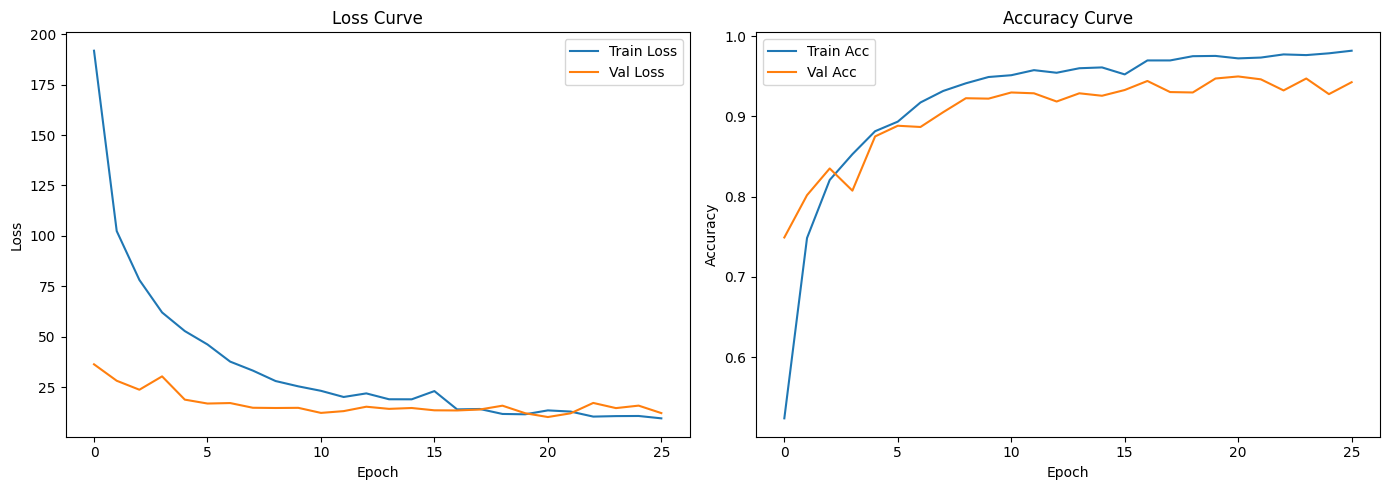

Loss & Accuracy curves saved to: CNN_models\loss_accuracy_curves.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Left: Loss Curve ---
axes[0].plot(train_losses, label="Train Loss")
axes[0].plot(val_losses, label="Val Loss")
axes[0].set_title("Loss Curve")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# --- Right: Accuracy Curve ---
axes[1].plot(train_accs, label="Train Acc")
axes[1].plot(val_accs, label="Val Acc")
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()

# ===== Simpan figure =====
plot_path = os.path.join("CNN_models", "loss_accuracy_curves.png")
plt.savefig(plot_path)
plt.show()
print(f"Loss & Accuracy curves saved to: {plot_path}")


TEST ACCURACY: 95.29%

CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.95      0.96       453
 Moderate Impairment       1.00      1.00      1.00       443
       No Impairment       0.93      0.94      0.94       554
Very Mild Impairment       0.92      0.92      0.92       504

            accuracy                           0.95      1954
           macro avg       0.96      0.95      0.95      1954
        weighted avg       0.95      0.95      0.95      1954



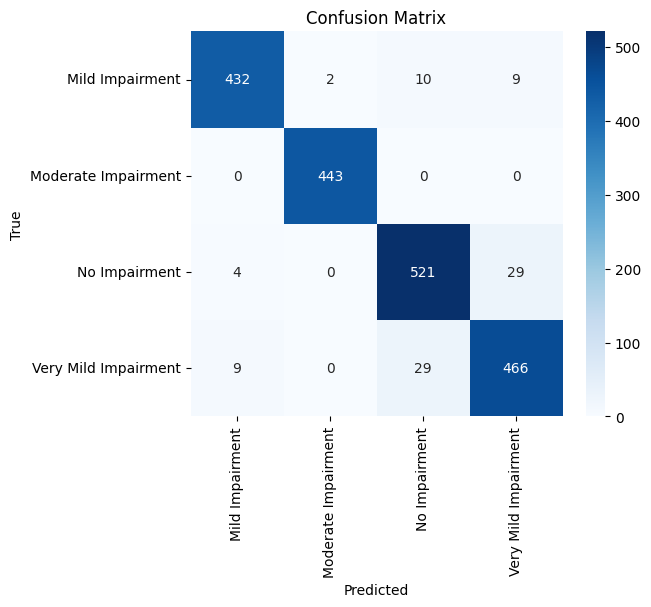

Confusion matrix saved to: CNN_models\confusion_matrix.png


In [10]:
# ===== Konfigurasi =====
model_path = "CNN_models/cnn_model_best_20251119-121302.pth"  # ganti dengan file model terbaik Anda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["Mild Impairment", "Moderate Impairment", "No Impairment", "Very Mild Impairment"]

# ===== Load model =====
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

y_true = []
y_pred = []

# ===== Testing =====
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ===== Test Accuracy =====
test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nTEST ACCURACY: {test_acc*100:.2f}%")

# ===== Classification Report =====
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")

# ===== Simpan plot ke folder CNN_models =====
os.makedirs("CNN_models", exist_ok=True)
cm_path = os.path.join("CNN_models", "confusion_matrix.png")
plt.savefig(cm_path)
plt.show()
print(f"Confusion matrix saved to: {cm_path}")

## Transformer (Pretrained)

### Pretrained ResNet50

In [40]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# ===== Config =====
base_dir = "processed_dataset"
img_size = 224
batch_size = 32
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", device)

save_dir = "ResNet_models"
os.makedirs(save_dir, exist_ok=True)


DEVICE: cuda


In [41]:
# ===== Transformasi =====
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ===== Load Dataset =====
train_ds = datasets.ImageFolder(f"{base_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{base_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{base_dir}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [42]:
# ===== Load Pretrained ResNet50 =====
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
print("Loaded Pretrained ResNet50")

# Freeze backbone (feature extractor)
for param in resnet.parameters():
    param.requires_grad = False

# Replace classifier
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
resnet = resnet.to(device)

# Loss & Optimizer (hanya classifier yang trainable)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)


Loaded Pretrained ResNet50


In [ ]:
best_val_acc = 0
patience_counter = 0
patience = 5

def train_resnet(epochs=30):
    global best_val_acc, patience_counter
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    epoch_times = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        # ===== Training =====
        resnet.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        train_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(train_acc)

        # ===== Validation =====
        resnet.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = resnet(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} "
              f"| Train Acc: {train_acc*100:.2f}% | Val Loss: {val_losses[-1]:.4f} "
              f"| Val Acc: {val_acc*100:.2f}% | Time: {epoch_time:.2f}s")

        # ===== Early Stopping & Save Best Model =====
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            model_path = os.path.join(save_dir, f"resnet50_best_{timestamp}.pth")
            torch.save(resnet.state_dict(), model_path)
            print(f">>> New best model saved: {model_path}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(">>> Early stopping triggered!")
            break

    total_time = time.time() - start_time
    print(f"\nTotal Training Time: {total_time:.2f} seconds")

    # ===== Total Parameters =====
    total_params = sum(p.numel() for p in resnet.parameters())
    print(f"Total parameters: {total_params}")

    return train_losses, val_losses, train_accs, val_accs, epoch_times


In [44]:
train_losses, val_losses, train_accs, val_accs, epoch_times = train_resnet(epochs=30)

Epoch 1/30 | Train Loss: 0.9038 | Train Acc: 63.07% | Val Loss: 0.7467 | Val Acc: 68.05% | Time: 64.21s
>>> New best model saved: ResNet_models\resnet50_best_20251118-102312.pth
Epoch 2/30 | Train Loss: 0.7018 | Train Acc: 70.22% | Val Loss: 0.6825 | Val Acc: 70.61% | Time: 63.26s
>>> New best model saved: ResNet_models\resnet50_best_20251118-102416.pth
Epoch 3/30 | Train Loss: 0.6390 | Train Acc: 73.32% | Val Loss: 0.6615 | Val Acc: 70.30% | Time: 62.24s
Epoch 4/30 | Train Loss: 0.6089 | Train Acc: 74.72% | Val Loss: 0.6424 | Val Acc: 71.38% | Time: 62.47s
>>> New best model saved: ResNet_models\resnet50_best_20251118-102621.pth
Epoch 5/30 | Train Loss: 0.5864 | Train Acc: 75.52% | Val Loss: 0.6337 | Val Acc: 71.27% | Time: 61.95s
Epoch 6/30 | Train Loss: 0.5611 | Train Acc: 76.50% | Val Loss: 0.6361 | Val Acc: 71.07% | Time: 63.57s
Epoch 7/30 | Train Loss: 0.5399 | Train Acc: 77.86% | Val Loss: 0.6205 | Val Acc: 71.27% | Time: 60.70s
Epoch 8/30 | Train Loss: 0.5350 | Train Acc: 77.76

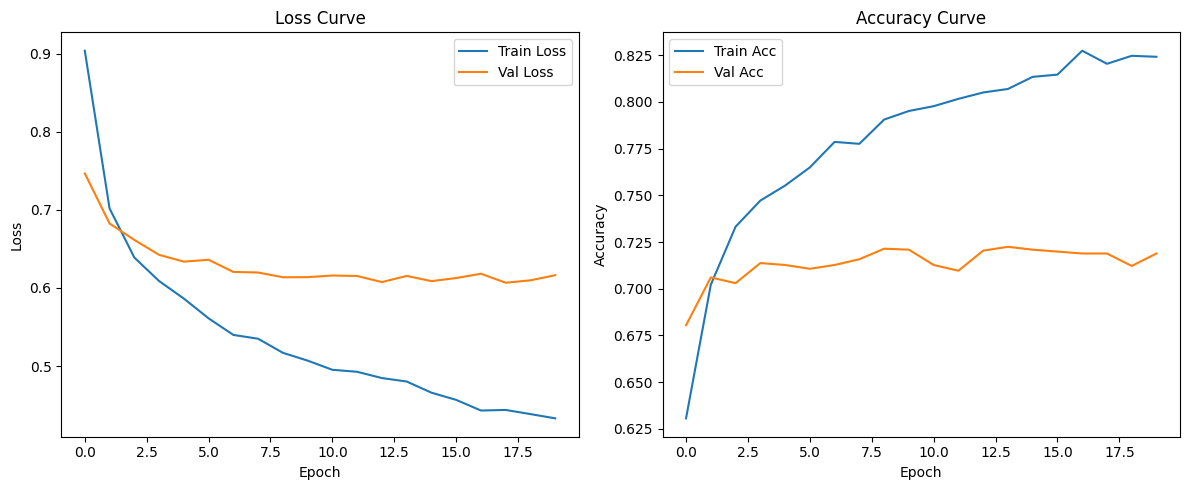

Plot saved to: ResNet_models\loss_accuracy_curve.png


In [45]:
# ===== Plot Loss & Accuracy Curves =====
plot_path = os.path.join(save_dir, "loss_accuracy_curve.png")

# Plot kiri-kanan
plt.figure(figsize=(12,5))

# === Loss Curve ===
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# === Accuracy Curve ===
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Simpan ke folder
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to: {plot_path}")


Test Accuracy: 72.67%

Classification Report:
                       precision    recall  f1-score   support

     Mild Impairment       0.82      0.69      0.75       453
 Moderate Impairment       1.00      0.97      0.98       443
       No Impairment       0.63      0.73      0.67       554
Very Mild Impairment       0.55      0.54      0.54       504

            accuracy                           0.73      1954
           macro avg       0.75      0.73      0.74      1954
        weighted avg       0.74      0.73      0.73      1954



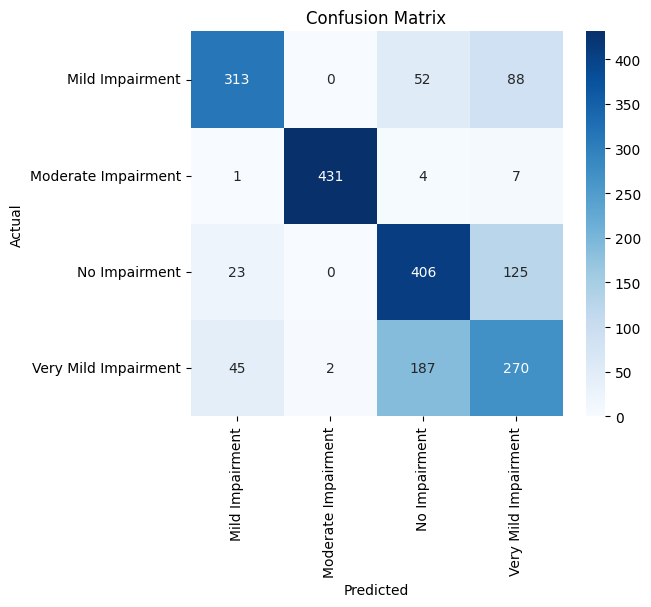

Confusion matrix saved to: ResNet_models\confusion_matrix.png


In [46]:
resnet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Test Accuracy ===
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# === Classification Report ===
report = classification_report(all_labels, all_preds, target_names=train_ds.classes)
print("\nClassification Report:\n", report)

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Simpan confusion matrix
cm_path = os.path.join(save_dir, "confusion_matrix.png")
plt.savefig(cm_path)
plt.show()
print(f"Confusion matrix saved to: {cm_path}")

### Fine-Tuning Normal (Partial Unfreeze)

In [47]:
# ===== Load Pretrained ResNet50 =====
from torchvision.models import resnet50, ResNet50_Weights

resnet_ft = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Unfreeze last two layers (layer4 + fc)
for name, param in resnet_ft.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace classifier
in_features = resnet_ft.fc.in_features
resnet_ft.fc = nn.Linear(in_features, num_classes)
resnet_ft = resnet_ft.to(device)

# Loss & Optimizer (only trainable params)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet_ft.parameters()), lr=1e-4)

print(resnet_ft)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
best_val_acc = 0
patience_counter = 0
patience = 5

def train_finetune_normal(epochs=30):
    global best_val_acc, patience_counter
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    epoch_times = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        # ===== Training =====
        resnet_ft.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer_ft.zero_grad()
            outputs = resnet_ft(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_ft.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        train_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(train_acc)

        # ===== Validation =====
        resnet_ft.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = resnet_ft(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"[FT Normal] Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} "
              f"| Train Acc: {train_acc*100:.2f}% | Val Loss: {val_losses[-1]:.4f} "
              f"| Val Acc: {val_acc*100:.2f}% | Time: {epoch_time:.2f}s")

        # Early stopping & save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            model_path = os.path.join(save_dir, f"resnet50_ft_normal_best_{timestamp}.pth")
            torch.save(resnet_ft.state_dict(), model_path)
            print(f">>> New best model saved: {model_path}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(">>> Early stopping triggered!")
            break

    total_time = time.time() - start_time
    print(f"\nTotal Training Time: {total_time:.2f} seconds")
    total_params = sum(p.numel() for p in resnet_ft.parameters())
    print(f"Total parameters: {total_params}")

    return train_losses, val_losses, train_accs, val_accs, epoch_times

In [49]:
train_losses_ft, val_losses_ft, train_accs_ft, val_accs_ft, epoch_times_ft = train_finetune_normal(epochs=30)

[FT Normal] Epoch 1/30 | Train Loss: 0.7030 | Train Acc: 68.90% | Val Loss: 0.5282 | Val Acc: 74.91% | Time: 68.41s
>>> New best model saved: ResNet_models\resnet50_ft_normal_best_20251118-104411.pth
[FT Normal] Epoch 2/30 | Train Loss: 0.2879 | Train Acc: 89.11% | Val Loss: 0.5617 | Val Acc: 78.19% | Time: 67.53s
>>> New best model saved: ResNet_models\resnet50_ft_normal_best_20251118-104518.pth
[FT Normal] Epoch 3/30 | Train Loss: 0.0707 | Train Acc: 97.93% | Val Loss: 0.6939 | Val Acc: 80.39% | Time: 66.12s
>>> New best model saved: ResNet_models\resnet50_ft_normal_best_20251118-104625.pth
[FT Normal] Epoch 4/30 | Train Loss: 0.0240 | Train Acc: 99.47% | Val Loss: 0.8150 | Val Acc: 79.57% | Time: 66.12s
[FT Normal] Epoch 5/30 | Train Loss: 0.0270 | Train Acc: 99.44% | Val Loss: 0.8233 | Val Acc: 79.98% | Time: 105.06s
[FT Normal] Epoch 6/30 | Train Loss: 0.0348 | Train Acc: 98.89% | Val Loss: 0.8226 | Val Acc: 81.00% | Time: 169.88s
>>> New best model saved: ResNet_models\resnet50_f

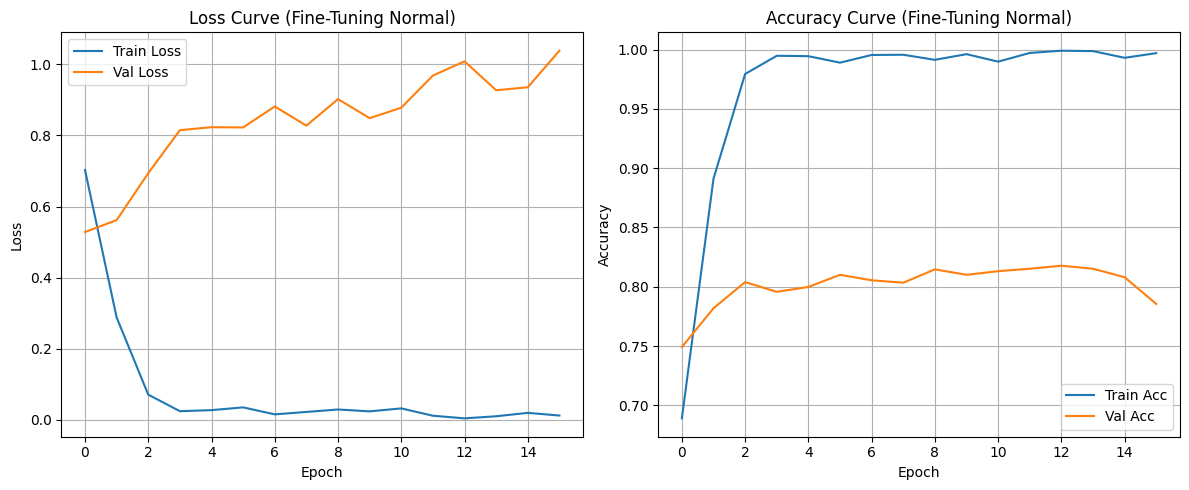

Plot Loss & Accuracy Fine-Tuning Normal tersimpan di: ResNet_models\fine_tuning_normal_curve.png


In [50]:
# ===== Plot Loss & Accuracy Curves Fine-Tuning Normal =====
plt.figure(figsize=(12,5))

# --- Loss Curve ---
plt.subplot(1,2,1)
plt.plot(train_losses_ft, label="Train Loss")
plt.plot(val_losses_ft, label="Val Loss")
plt.title("Loss Curve (Fine-Tuning Normal)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Accuracy Curve ---
plt.subplot(1,2,2)
plt.plot(train_accs_ft, label="Train Acc")
plt.plot(val_accs_ft, label="Val Acc")
plt.title("Accuracy Curve (Fine-Tuning Normal)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Simpan figure
plot_path = os.path.join(save_dir, "fine_tuning_normal_curve.png")
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"Plot Loss & Accuracy Fine-Tuning Normal tersimpan di: {plot_path}")



Test Accuracy (Fine-Tuning Normal): 78.40%

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.86      0.84      0.85       453
 Moderate Impairment       1.00      0.98      0.99       443
       No Impairment       0.86      0.52      0.65       554
Very Mild Impairment       0.58      0.86      0.69       504

            accuracy                           0.78      1954
           macro avg       0.83      0.80      0.79      1954
        weighted avg       0.82      0.78      0.78      1954



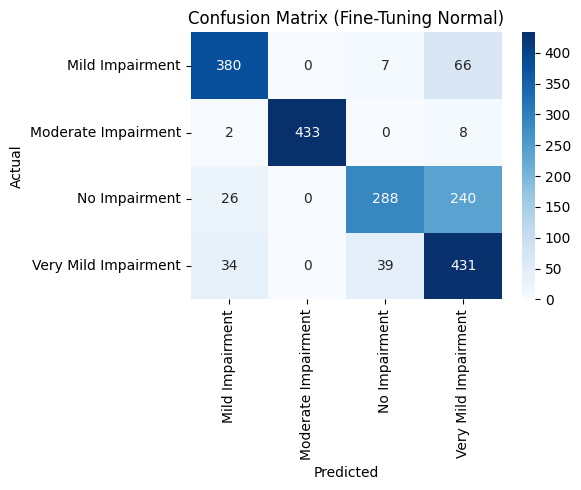

Confusion Matrix tersimpan di: ResNet_models\confusion_matrix_fine_tuning_normal.png


In [51]:
# --- Evaluasi Test Set ---
resnet_ft.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_ft(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Test Accuracy ---
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy (Fine-Tuning Normal): {test_acc*100:.2f}%")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Fine-Tuning Normal)")

# Simpan plot
cm_path = os.path.join(save_dir, "confusion_matrix_fine_tuning_normal.png")
plt.tight_layout()
plt.savefig(cm_path)
plt.show()

print(f"Confusion Matrix tersimpan di: {cm_path}")

### Fine-Tuning LoRA

In [52]:
class LoRALinear(nn.Module):
    def __init__(self, linear, r=4, alpha=16):
        super().__init__()
        self.linear = linear
        self.r = r
        self.alpha = alpha
        self.lora_down = nn.Linear(linear.in_features, r, bias=False)
        self.lora_up = nn.Linear(r, linear.out_features, bias=False)
        # scaling
        self.scaling = alpha / r

        # freeze original weights
        self.linear.weight.requires_grad = False
        if self.linear.bias is not None:
            self.linear.bias.requires_grad = False

    def forward(self, x):
        return self.linear(x) + self.lora_up(self.lora_down(x)) * self.scaling


In [53]:
from copy import deepcopy

def apply_lora_to_resnet(model, r=4, alpha=16):
    model = deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            parent = model
            name_parts = name.split(".")
            for p in name_parts[:-1]:
                parent = getattr(parent, p)
            setattr(parent, name_parts[-1], LoRALinear(module, r=r, alpha=alpha))
    return model

resnet_lora = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
in_features = resnet_lora.fc.in_features
resnet_lora.fc = nn.Linear(in_features, num_classes)
resnet_lora = apply_lora_to_resnet(resnet_lora, r=8, alpha=16).to(device)

optimizer_lora = optim.Adam(filter(lambda p: p.requires_grad, resnet_lora.parameters()), lr=2e-4)
criterion = nn.CrossEntropyLoss()


In [54]:
best_val_acc = 0
patience_counter = 0
patience = 5

def train_lora(epochs=30):
    global best_val_acc, patience_counter
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    epoch_times = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        # ===== Training =====
        resnet_lora.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer_lora.zero_grad()
            outputs = resnet_lora(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_lora.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        train_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(train_acc)

        # ===== Validation =====
        resnet_lora.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = resnet_lora(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        val_acc = val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"[LoRA FT] Epoch {epoch+1}/{epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% | Time: {epoch_time:.2f}s")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            model_path = os.path.join(save_dir, f"resnet50_lora_best_{timestamp}.pth")
            torch.save(resnet_lora.state_dict(), model_path)
            print(f">>> New best LoRA model saved: {model_path}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(">>> Early stopping triggered!")
            break

    total_time = time.time() - start_time
    total_params = sum(p.numel() for p in resnet_lora.parameters())
    print(f"\nTotal Training Time: {total_time:.2f} seconds | Total parameters: {total_params}")
    return train_losses, val_losses, train_accs, val_accs, epoch_times


In [55]:
train_losses_lora, val_losses_lora, train_accs_lora, val_accs_lora, epoch_times_lora = train_lora(epochs=30)

[LoRA FT] Epoch 1/30 | Train Acc: 75.49% | Val Acc: 81.87% | Time: 378.13s
>>> New best LoRA model saved: ResNet_models\resnet50_lora_best_20251118-111309.pth
[LoRA FT] Epoch 2/30 | Train Acc: 89.64% | Val Acc: 89.86% | Time: 375.12s
>>> New best LoRA model saved: ResNet_models\resnet50_lora_best_20251118-111925.pth
[LoRA FT] Epoch 3/30 | Train Acc: 96.23% | Val Acc: 87.76% | Time: 374.71s
[LoRA FT] Epoch 4/30 | Train Acc: 97.27% | Val Acc: 91.76% | Time: 374.40s
>>> New best LoRA model saved: ResNet_models\resnet50_lora_best_20251118-113154.pth
[LoRA FT] Epoch 5/30 | Train Acc: 98.69% | Val Acc: 92.88% | Time: 375.84s
>>> New best LoRA model saved: ResNet_models\resnet50_lora_best_20251118-113810.pth
[LoRA FT] Epoch 6/30 | Train Acc: 99.15% | Val Acc: 92.52% | Time: 415.18s
[LoRA FT] Epoch 7/30 | Train Acc: 99.47% | Val Acc: 76.34% | Time: 529.57s
[LoRA FT] Epoch 8/30 | Train Acc: 99.42% | Val Acc: 94.01% | Time: 659.14s
>>> New best LoRA model saved: ResNet_models\resnet50_lora_best_

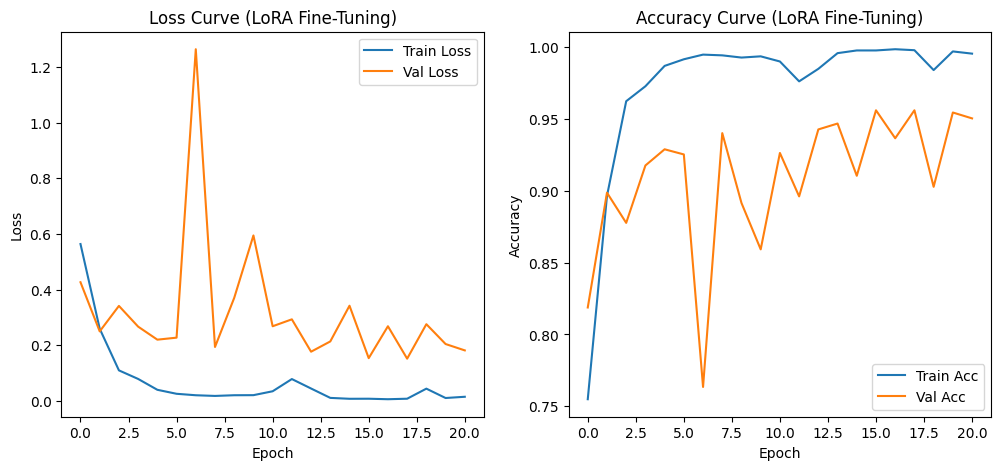

Loss & Accuracy curve saved at: ResNet_models\loss_acc_curve_lora_ft.png


In [56]:
# === Plot Loss & Accuracy Curve (LoRA FT) ===
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses_lora, label="Train Loss")
plt.plot(val_losses_lora, label="Val Loss")
plt.title("Loss Curve (LoRA Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs_lora, label="Train Acc")
plt.plot(val_accs_lora, label="Val Acc")
plt.title("Accuracy Curve (LoRA Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Simpan plot
plot_path = os.path.join(save_dir, "loss_acc_curve_lora_ft.png")
plt.savefig(plot_path)
plt.show()

print(f"Loss & Accuracy curve saved at: {plot_path}")



Test Accuracy (LoRA FT): 95.45%

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.95      0.96       453
 Moderate Impairment       1.00      1.00      1.00       443
       No Impairment       0.90      0.99      0.94       554
Very Mild Impairment       0.97      0.88      0.93       504

            accuracy                           0.95      1954
           macro avg       0.96      0.96      0.96      1954
        weighted avg       0.96      0.95      0.95      1954



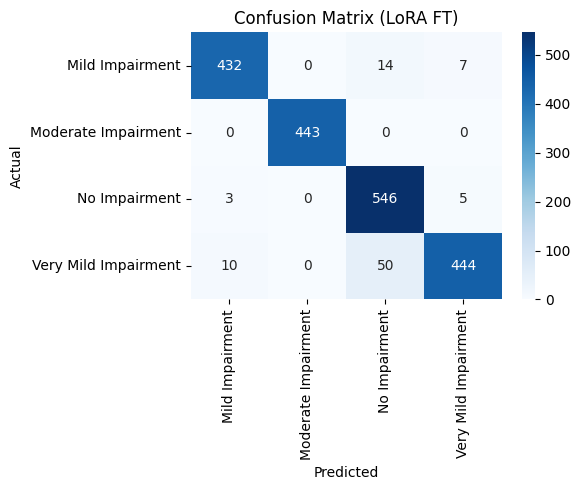

Confusion Matrix tersimpan di: ResNet_models\confusion_matrix_lora_ft.png


In [57]:
# --- Evaluasi Test Set untuk LoRA ---
resnet_lora.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_lora(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Test Accuracy ---
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy (LoRA FT): {test_acc*100:.2f}%")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LoRA FT)")

# Simpan plot
cm_path = os.path.join(save_dir, "confusion_matrix_lora_ft.png")
plt.tight_layout()
plt.savefig(cm_path)
plt.show()

print(f"Confusion Matrix tersimpan di: {cm_path}")


## Transformer (Vision Transformer)